<a href="https://colab.research.google.com/github/Bharath2/cube/blob/master/Copy_of_biped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**import modules**

In [2]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install mitdeeplearning
!pip install recordclass
!pip install box2d box2d-py box2d-kengz

     |████████████████████████████████| 2.1MB 10.5MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115442 sha256=95d68bb442f017ca62b0051065ccda61e2ca5776569adb6112c9a84d71dba083
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning
     |████████████████████████████████| 163kB 12.8MB/s 
  Created wheel for recordclass: filename=recordclass-0.14.3-cp37-cp37m-linux_x86_64.whl size=344653 sha256=4054e5fd1db4810fce0a22d9a14fc9343559fa2127fce4809b89cdeaf95dd3c8
  Stored in directory: /root/.cache/pip/wheels/c2/fa/9f/abec56a7c5d6843a053f2aa53166c556be33c169438c57e483
Successfully built recordclass
     |████████████████████████████████| 1.3MB 12.3MB/s 
     |████████████████████████████████| 450kB 54.3MB/s 
     |████████████████████████████████| 430kB 65.5MB/s 
  ERROR: Failed building wheel for box2d-kengz
  Running setup.py clean for box2d-kengz
Failed t

In [3]:
import time, gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import count

In [4]:
env = gym.make('BipedalWalkerHardcore-v3')
env.reset()
# for _ in range(1000):
#     env.render()
#     env.step(env.action_space.sample()) # take a random action
# env.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 2.74617644e-03,  8.49179400e-06, -1.10731859e-03, -1.60000563e-02,
        9.24239382e-02,  2.57058535e-03,  8.59860599e-01, -6.41013961e-04,
        1.00000000e+00,  3.27568315e-02,  2.57046497e-03,  8.53567854e-01,
       -1.74905096e-03,  1.00000000e+00,  4.40813482e-01,  4.45819587e-01,
        4.61422235e-01,  4.89549607e-01,  5.34102142e-01,  6.02460325e-01,
        7.09148049e-01,  8.85930717e-01,  1.00000000e+00,  1.00000000e+00])

In [5]:
from pyvirtualdisplay import Display
from mitdeeplearning.lab3 import play_video
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def save_video(env, model, name):
    display = Display(visible=0, size=(400, 300))
    display.start()

    filename = name + ".mp4"
    video_recorder = VideoRecorder(env, filename, enabled=True)
    
    counter = 0
    action = [0]
    done = 0
    obs = env.reset()
    while not done:
        env.render()
        video_recorder.capture_frame() 
        action = model(obs)
        obs, reward, done, info = env.step(action)
        counter += 1
        # if counter > 100: done = 1

    video_recorder.close()
    video_recorder.enabled = False
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename

In [6]:
save_video(env, lambda x: [0]*4, 'a')
play_video('a.mp4')

Successfully saved 122 frames into a.mp4!


#Import Torch

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

# if gpu is to be used
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  device = torch.device("cpu")
  torch.set_default_tensor_type(torch.FloatTensor)

##Util to Plot reward


In [8]:
from IPython import display as ipythondisplay

tic = time.time()
def plot(reward):
    global tic
    if time.time() - tic > 2:

      plt.cla()
      plt.plot(reward)
      plt.xlabel('episodes')
      plt.ylabel('rewards')

      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      tic = time.time()

In [9]:
from recordclass import recordclass

Transitions = recordclass('Transitions', ('states', 'actions', 'next_states', 'rewards', 'dones'))

class ReplayMemory():
    def __init__(self, capacity=1000, num_states = 24, num_actions = 4):
      
        self.length = 0
        self.capacity = capacity

        self.states = np.zeros((capacity, num_states))
        self.actions = np.zeros((capacity, num_actions))
        self.next_states = np.zeros((capacity, num_states))
        self.rewards = np.zeros((capacity, 1))
        self.dones = np.zeros((capacity, 1))

    def add_transition(self, *args):
        index = self.length % self.capacity

        self.states[index] = args[0]
        self.actions[index] = args[1]
        self.next_states[index] = args[2]
        self.rewards[index] = args[3]
        self.dones[index] = args[4]

        self.length += 1

    def sample(self, batch_size):

        maxind = min(self.length, self.capacity)
        inds = np.random.choice(maxind, batch_size)

        batch = Transitions(self.states[inds],
                     self.actions[inds],
                     self.next_states[inds],
                     self.rewards[inds],
                     self.dones[inds])
        
        for i in range(5):
          batch[i] = torch.tensor(batch[i], dtype=torch.float)

        return batch
        
    def __len__(self):
      return self.length

#**Q-value Network**

In [10]:
class DQN(nn.Module):

    def __init__(self, state_dim = 24, action_dim = 4):
        super(DQN, self).__init__()
        self.l11 = nn.Linear(state_dim, 64)
        self.l13 = nn.Linear(action_dim, 16)
        self.l2 = nn.Linear(80, 256)

        self.l3 = nn.Linear(256, 1)
        self.l3.weight.data.uniform_(-0.003,0.003)
        self.l3.bias.data.fill_(0.001)

    def forward(self, states, actions):
        states = torch.relu(self.l11(states))
        actions = torch.relu(self.l13(actions))
        x = torch.cat((states, actions),1)
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return x


#**Double DQN critic** 

In [11]:
class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.q1 = DQN()
    self.q2 = DQN()
  
  def predict(self, states,  actions):
    q1 = self.q1(states,actions)
    q2 = self.q2(states,actions)
    return q1, q2
  
  def forward(self, states,actions):
    q1, q2 = self.predict(states,actions)
    return torch.min(q1, q2)
  
  def Cal_loss(self, expected_critic_values, batch):
    q1, q2 = self.predict(batch.states, batch.actions)
    loss1 = F.smooth_l1_loss(expected_critic_values, q1)
    loss2 = F.smooth_l1_loss(expected_critic_values, q2)
    return loss1 + loss2

#**Policy network**

In [12]:
class Policy(nn.Module):

    def __init__(self, state_dim = 24, action_dim = 4, action_limit = 1):
        super(Policy, self).__init__()

        self.act_lim = action_limit

        self.l11 = nn.Linear(state_dim, 64)
        self.l2 = nn.Linear(64, 256)

        self.mean_layer = nn.Linear(256, action_dim)
        self.mean_layer.weight.data.uniform_(-0.01,0.01)
        self.mean_layer.bias.data.fill_(0.01)

        self.log_std = nn.Linear(256, action_dim)
        self.log_std.weight.data.uniform_(-0.005,0.005)
        self.log_std.bias.data.fill_(0.005)

    def forward(self, states, training = True):
        states = torch.relu(self.l11(states))
        x = torch.relu(self.l2(states))

        mean = self.mean_layer(x)
        std = torch.exp(self.log_std(x).clamp(-20, 2))

        if not training:
          sample = mean
        else:
          sample = mean + std * torch.randn(mean.size())

        action = torch.tanh(sample)

        log_probs = Normal(mean, std).log_prob(sample) - torch.log(1 - action**2 + 1e-8)

        return self.act_lim * action, std, log_probs

    def choose_action(self, state, training = True, verb = 0):
        state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
        action, std, _  = self.forward(state,  training)
        action, std = action.cpu().detach().numpy(), std.cpu().detach().numpy()
        if verb: print(action, std)
        
        return [np.round(action[0], 5)]
        

##Traininig utils

In [13]:
def Optimize(model, optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1) 
        # param.grad.data[torch.isnan(param.grad.data)] = 0
    optimizer.step()

In [14]:
def soft_update(target, source, tau):
	for a, b in zip(target.parameters(), source.parameters()):
		a.data.copy_(a.data * (1.0 - tau) + b.data * tau)

#**Initialize**

In [15]:
gamma = 0.99

actor = Policy().to(device)
target_actor = Policy().to(device)

critic = Critic().to(device)
target_critic = Critic().to(device)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

memory = ReplayMemory(300000)

actor_optimizer = optim.Adam(actor.parameters(),1e-3)
critic_optimizer = optim.Adam(critic.parameters(),1e-3)


reward_list = []
avg_rewards = []

#**Single training step**

In [16]:
def train_step():
    if len(memory) < 64: return

    batch = memory.sample(64)

  #---------------------critic training----------------------------------
    next_actions, std, log_probs = actor(batch.next_states)
    next_critic_values = target_critic(batch.next_states, next_actions).detach()

    expected_critic_values = batch.rewards + gamma * (1-batch.dones)*(next_critic_values - 0.1*log_probs)

    critic_loss = critic.Cal_loss(expected_critic_values.detach(), batch)

    Optimize(critic, critic_optimizer, critic_loss)
  #---------------------------------------------------------------------


  #-----------------Freeze critic parameters-----------------------------
    for param in critic.parameters():
        param.requires_grad = False
  #------------------------------------------------------------------------


  #---------------------actor training----------------------------------
    actions, std, log_probs = actor(batch.states)
    critic_value = critic(batch.states, actions)
    actor_loss = -torch.mean(critic_value - 0.1*log_probs)

    Optimize(actor, actor_optimizer, actor_loss)
  #-----------------------------------------------------------------------


  #--------------------UnFreeze critic parameters-----------------------------
    for param in critic.parameters():
        param.requires_grad = True
  #-------------------------------------------------------------------------


  #----------------soft update targets--------------------------------------
    soft_update(target_actor, actor, 0.005)
    soft_update(target_critic, critic, 0.005)
  #-------------------------------------------------------------------------

#**Training**

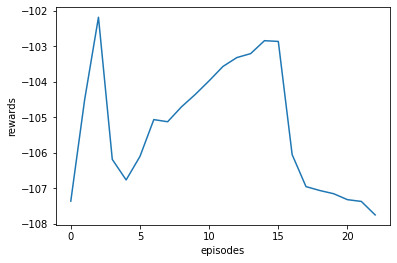

  6%|▌         | 23/400 [00:30<07:10,  1.14s/it]

In [ ]:
env = gym.make('BipedalWalkerHardcore-v3')

for i_episode in tqdm(range(400)):

  state = env.reset()
  total_reward = 0
  print(state)

  done = 0

  while not done:

    action = actor.choose_action(state)
    next_state, reward, done, info = env.step(action[0])
    memory.add_transition(state, action[0], next_state, reward, done)
    
    train_step()
    total_reward += reward
    state = next_state

  reward_list.append(total_reward)
  avg_rewards.append(np.mean(reward_list[-40:])) 

  plot(avg_rewards)

In [ ]:
torch.save({
          'actor': target_actor.state_dict(),
          'critic': target_critic.state_dict(),
          'actor_optimizer': actor_optimizer.state_dict(),
          'critic_optimizer': critic_optimizer.state_dict()
          }, 'bestwalker')


In [ ]:
from google.colab import files
files.download('bestwalker') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Test Learned Policy

In [ ]:
def policy(x):
  # print(x)
  return actor.choose_action(x, False)[0]

In [ ]:
save_video(env, policy , 'a')
play_video('a.mp4')

Successfully saved 911 frames into a.mp4!


In [ ]:
files.download('a.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>